In [13]:
import pandas as pd
import numpy as np
import glob
import laspy
#import open3d as o3d
import cv2

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image

In [14]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'/ImagesGroundRemovedSmall/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'/LazFilesWithHeightRemoved/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

In [15]:
def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return (MaxMinNormalize(arr))*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6134_518_max.tif
4095


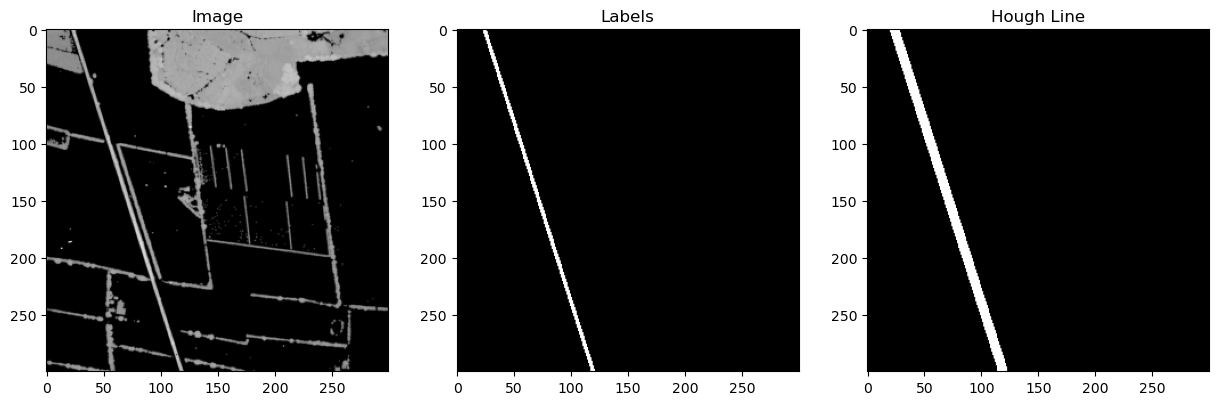

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6146_468_max.tif
4095


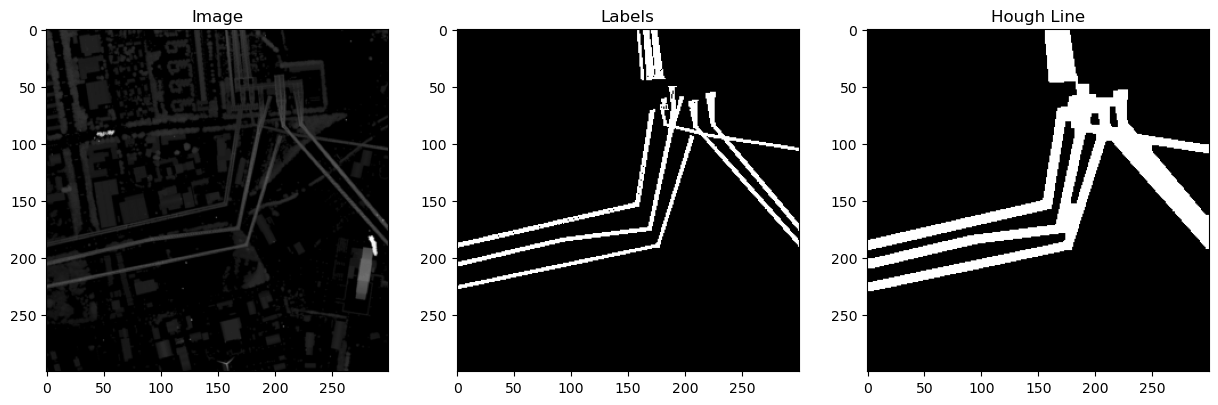

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6161_465_max.tif
4095


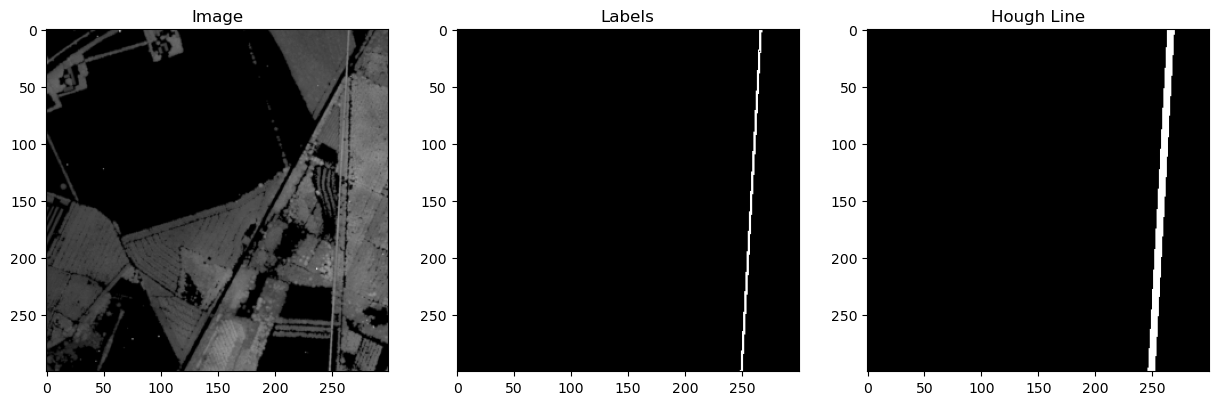

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6162_472_max.tif
4095


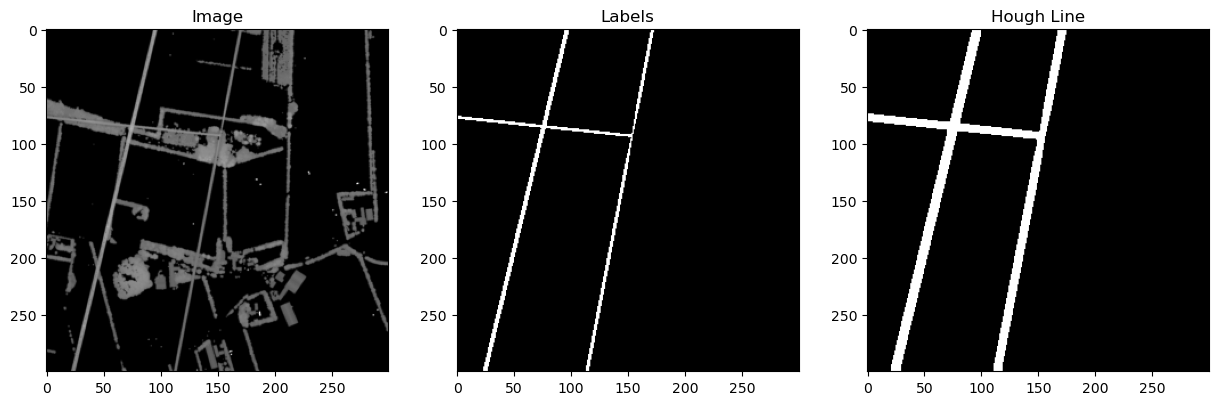

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6163_472_max.tif
4095


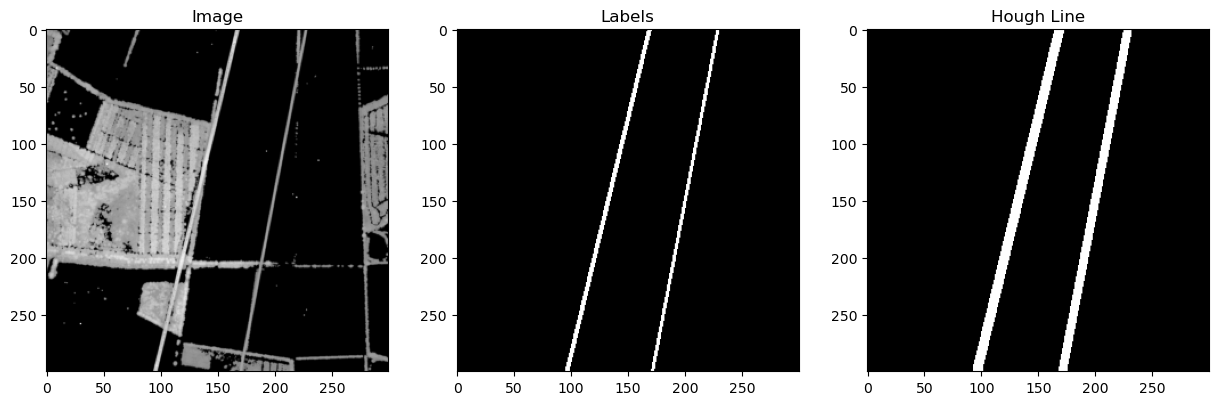

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_473_max.tif
4095


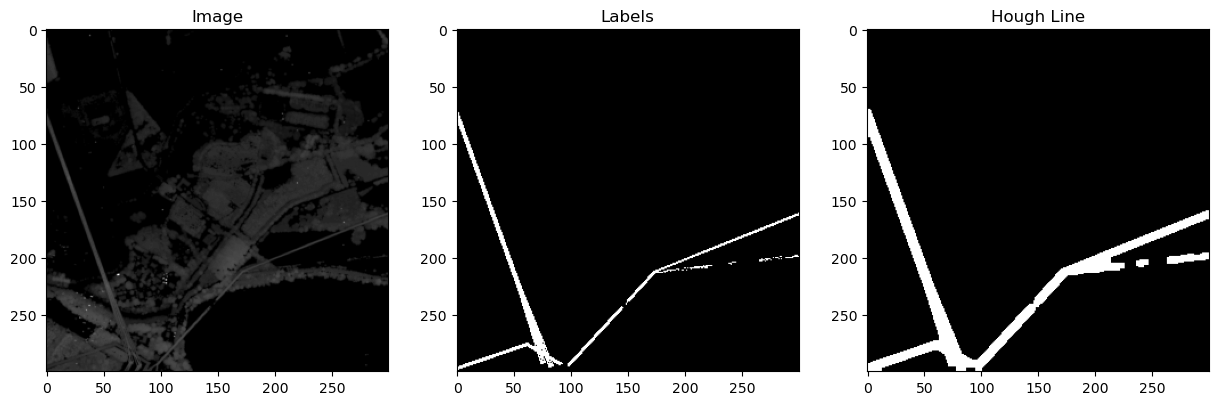

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_474_max.tif
4095


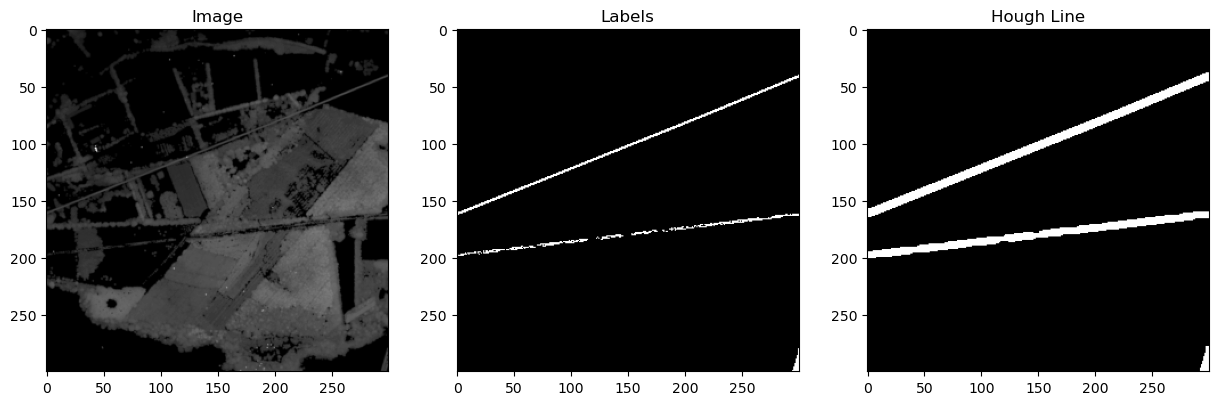

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_475_max.tif
4095


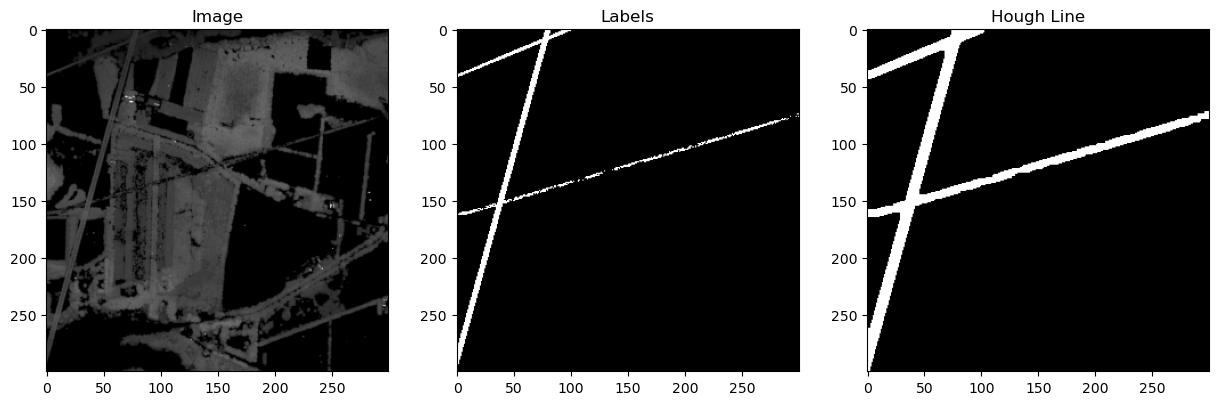

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6168_458_max.tif
4095


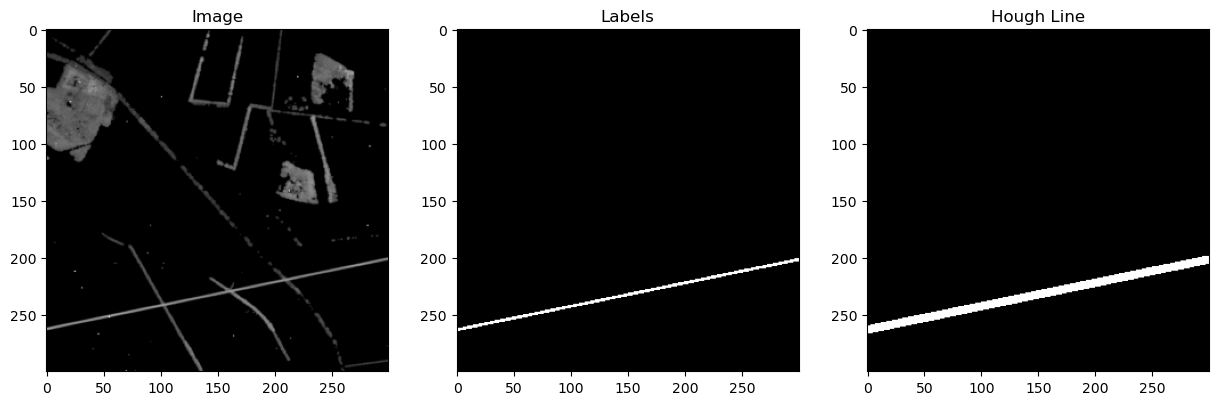

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6204_505_max.tif
4095


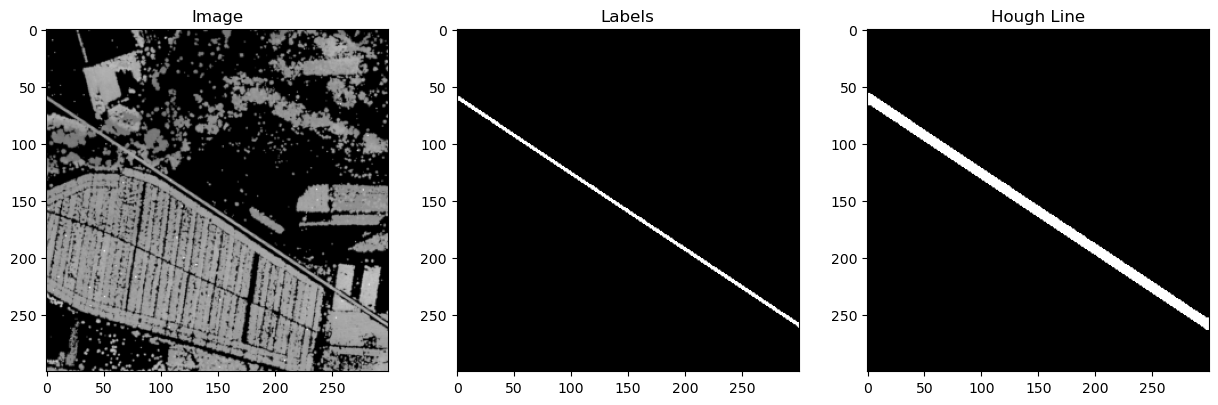

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6205_513_max.tif
4095


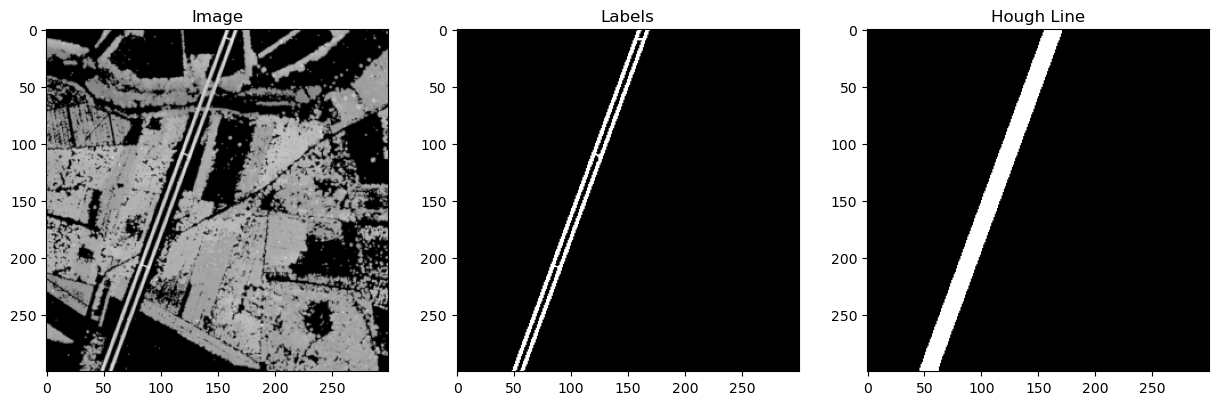

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6211_474_max.tif
4095


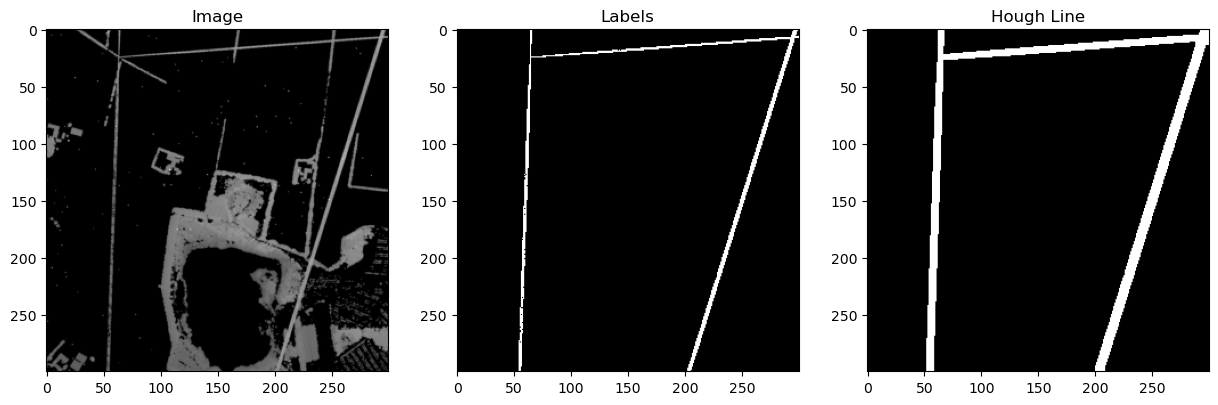

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6219_494_max.tif
4095


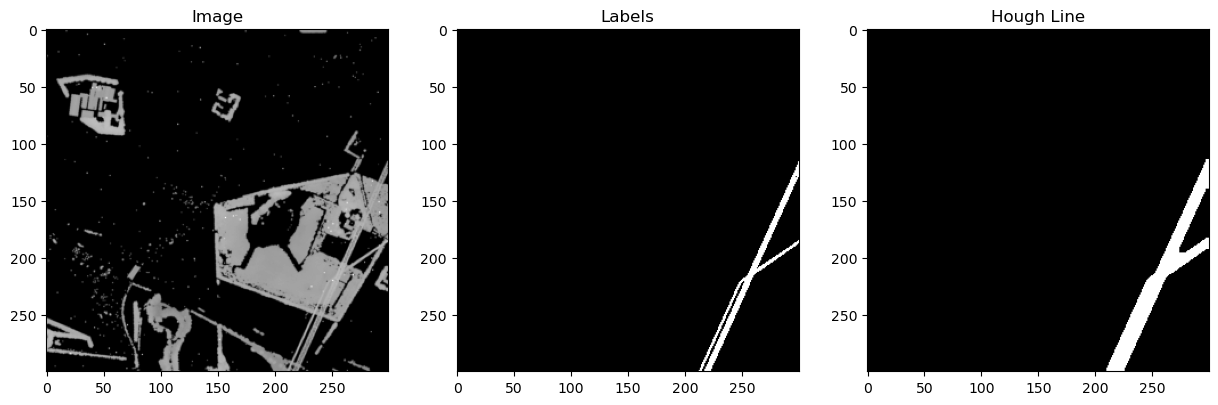

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6220_495_max.tif
4095


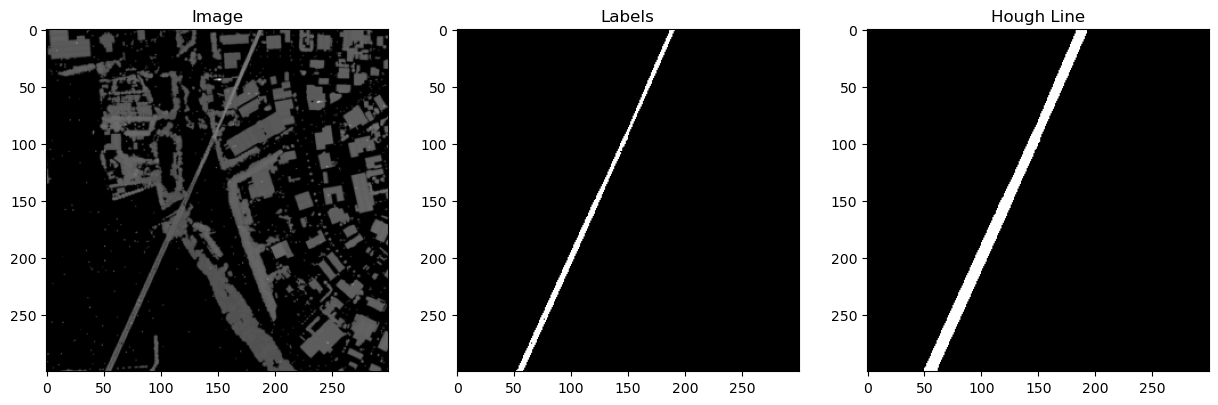

/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6221_452_max.tif
4095


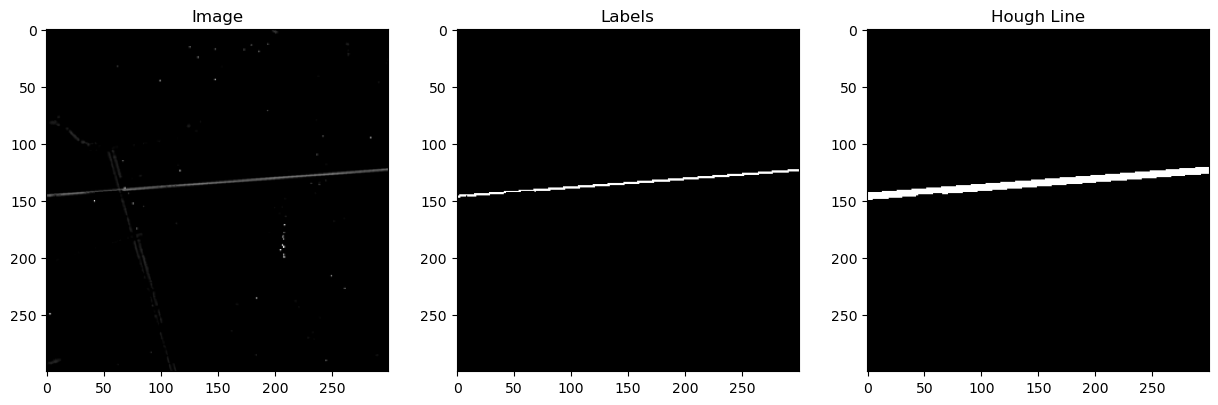

11 11
2 2
2 2


In [4]:
all_path_relations = GetPathRelations("/home/frederik/data/TestData/data")
path_tuples = list(zip(*all_path_relations))

# Normalize to -1 and 1
transform_img_gray = transforms.Compose(
    [transforms.Resize((992,992)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])


# Open images
trainingImages = []
labelImages = []
    
for path in path_tuples:
    image_path, laz_path = path
    print(image_path)
    
    # Image to training set
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)
    
    image = Image.fromarray(image)
    transformed_image = transform_img_gray(image)
    _, x_pixels, y_pixels = transformed_image.shape
    trainingImages.append(transform_img_gray(image))
    
    # Generate labels 
    las = laspy.read(laz_path, laz_backend=laspy.compression.LazBackend.LazrsParallel)
    
    y_values = np.rint(CastAllXValuesToImage(las.X, y_pixels)).astype(np.int32)
    x_values = np.rint(CastAllYValuesToImage(las.Y, x_pixels)).astype(np.int32)
    
    powerline_mask = (las.classification == 14)
    x_powerline_values = x_values[powerline_mask]
    x_powerline_values = np.where(x_powerline_values < x_pixels, x_powerline_values, x_pixels-1)
    x_powerline_values = np.where(x_powerline_values >= 0, x_powerline_values, 0)
    
    y_powerline_values = y_values[powerline_mask]
    y_powerline_values = np.where(y_powerline_values < y_pixels, y_powerline_values, y_pixels-1)
    y_powerline_values = np.where(y_powerline_values >= 0, y_powerline_values, 0)
    
    labels = np.zeros((x_pixels, y_pixels)).astype(np.uint8)
    for i in range(len(x_powerline_values)):
        labels[x_powerline_values[i], y_powerline_values[i]] = 255
    
    # Create kernel
    kernel = np.ones((3, 3), np.uint8)
    #lines_image = cv2.morphologyEx(lines_image, cv2.MORPH_CLOSE, kernel)
    lines_image = cv2.dilate(labels, kernel, iterations=4)
    lines_image = cv2.erode(lines_image, kernel, iterations=2)
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,15))
    ax0.set_title('Image')
    ax0.imshow(transformed_image[0], cmap='gray')
    ax1.set_title('Labels')
    ax1.imshow(labels, cmap='gray')
    ax2.set_title('Hough Line')
    ax2.imshow(lines_image, cmap='gray')
    #ax0.axis('off')
    #ax1.axis('off')
    #ax2.axis('off')
    plt.show()
    
    lines_image = Image.fromarray(lines_image)
    labelImages.append(transform_img_gray(lines_image))
    

X_train, X_test, Y_train, Y_test = train_test_split(trainingImages, labelImages, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))


# Setting up sets for trainlodader and validation loader
training_set = []
for i in range(len(X_train)):
    training_set.append([X_train[i], Y_train[i]])
    
validation_set = []
for i in range(len(Y_val)):
    validation_set.append([X_val[i], Y_val[i]])
    
test_set = []
for i in range(len(Y_test)):
    test_set.append([X_test[i], Y_test[i]])

trainloader = torch.utils.data.DataLoader(training_set, batch_size=1, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=1, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4)

In [6]:
#torch.save(valloader, "valloader.pt")
torch.save(testloader, "testloader.pt")
torch.save(trainloader, "trainloader.pt")


In [13]:
trainloader = torch.load("trainloader.pt")
#valloader = torch.load("valloader.pt")
testloader = torch.load("testloader.pt")


In [7]:
for i, data in enumerate(trainloader):
    # get the input
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    assert(inputs.shape==labels.shape)
    #print(labels)

torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])


In [10]:
class ConvNetRGB(nn.Module):
    def __init__(self):
        super(ConvNetRGB, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            ).cuda()
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)).cuda()
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)).cuda()
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)).cuda()
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)).cuda()


        self.down1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024, out_channels=1024,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1),
                                   nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                        stride = 1, kernel_size=3, padding = 1)
                                  ).cuda()
        
        self.down2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1),
                                   nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                        stride = 1, kernel_size=3, padding = 1)
                                  ).cuda()
        
        self.down3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1),
                                   nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                        stride = 1, kernel_size=3, padding = 1)
                                  ).cuda()
        
        self.down4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1),
                                   nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                        stride = 1, kernel_size=3, padding = 1)
                                  ).cuda()
        
        self.down5 = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1),
                                   nn.ConvTranspose2d(in_channels=64, out_channels=1,
                                        stride = 1, kernel_size=3, padding = 1)
                                  ).cuda()
        
        

        
    def forward(self, x):
        print(f"Input: {x.shape}")
        out = self.layer1(x)
        print(f"self.layer1 {out.shape}")
        out = self.layer2(out)
        print(f"self.layer2 {out.shape}")
        out = self.layer3(out)
        print(f"self.layer3 {out.shape}")
        out = self.layer4(out)
        print(f"self.layer4 {out.shape}")
        out= self.layer5(out)
        print(f"self.layer5 {out.shape}")
        out = self.down1(out)
        print(f"self.down1 {out.shape}")
        out = self.down2(out)
        print(f"self.down2 {out.shape}")
        out = self.down3(out)
        print(f"self.down3 {out.shape}")
        out = self.down4(out)
        print(f"self.down4 {out.shape}")
        out = self.down5(out)
        print(f"self.down5 {out.shape}")
        #out = torch.sigmoid(out)
        return out

In [11]:
def ConvNetTraining(trainloader, valloader, Conv, lossFunction, learning_rate, epochs):
    model = Conv
    num_epochs = epochs
    criterion = lossFunction.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=learning_rate, total_iters=epochs)
    
    # loss arrays for figures
    TrainingLossArray = []
    ValidationLossArray = []
    
    early_stopping = 20
    notImproved = 0
    bestLoss = None
    bestModel = None
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print(f"LR = {scheduler.get_last_lr()[0]}")
        running_loss = 0.0
        for j, data in enumerate(trainloader):
            # get the input
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize            
            outputs = model(inputs.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Appending the mean running loss
        TrainingLossArray.append(running_loss/(j+1))
        
        # print("Training loss: ", running_loss/j)
        
        # Finding validation loss
        validation_loss = 0
        with torch.no_grad():
            for i, data in enumerate(valloader):
                # get the inputs
                inputs, labels = data
                
                #Calculates loss
                outputs = model(inputs.cuda())            
                loss = criterion(outputs.cuda(), labels.cuda())      
                validation_loss += loss.item()
        # Appending the mean validation loss
        ValidationLossArray.append(validation_loss/(i+1))
        # print("Validation loss: ", validation_loss/i)
        print(f"epoch = {epoch}, Validation loss: {validation_loss/(i+1):.7f}, Training loss: {running_loss/(j+1):.7f}")
        
        # Initialising params for early stopping
        if bestLoss == None:
            bestLoss = validation_loss
        
        # Checks for early stopping        
        if validation_loss <= bestLoss:
            notImproved = 0
            bestLoss = validation_loss
            bestModel = model
            torch.save(bestModel, "bestModel.pth")
        else:
            notImproved +=1
        # Converges if the training has not improved for a certain amount of iterations
        if notImproved >= early_stopping:
            break
        scheduler.step()
        
    return bestModel, ValidationLossArray, TrainingLossArray

In [12]:
bestModel, ValidationLossArray, TrainingLossArray = ConvNetTraining(trainloader, valloader, ConvNetRGB(), nn.MSELoss(), 0.001, 1000)

with open('valLoss.npy', 'wb') as f:
    np.save(f, np.array(ValidationLossArray))

with open('trainLoss.npy', 'wb') as f:
    np.save(f, np.array(TrainingLossArray))


LR = 1e-06
Input: torch.Size([1, 1, 300, 300])
self.layer1 torch.Size([1, 64, 150, 150])
self.layer2 torch.Size([1, 128, 75, 75])
self.layer3 torch.Size([1, 256, 37, 37])
self.layer4 torch.Size([1, 512, 18, 18])
self.layer5 torch.Size([1, 1024, 9, 9])
self.down1 torch.Size([1, 512, 18, 18])
self.down2 torch.Size([1, 256, 36, 36])
self.down3 torch.Size([1, 128, 72, 72])
self.down4 torch.Size([1, 64, 144, 144])
self.down5 torch.Size([1, 1, 288, 288])


/home/frederik/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1, 300, 300])) that is different to the input size (torch.Size([1, 1, 288, 288])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (288) must match the size of tensor b (300) at non-singleton dimension 3

In [10]:
np.min(ValidationLossArray)

0.10332294926047325

In [11]:
bestModel = torch.load("bestModel.pth")

0
Max Outputs:  tensor(-0.0700)
0
Max Outputs:  tensor(-0.0707)


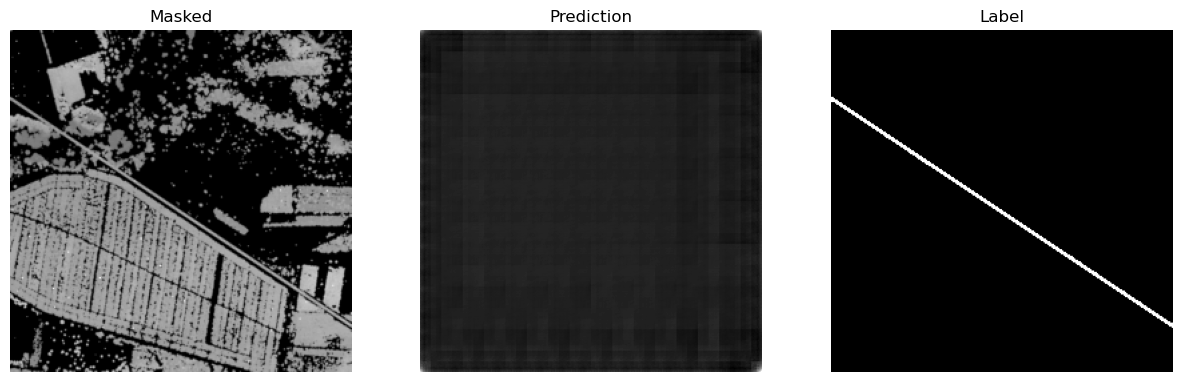

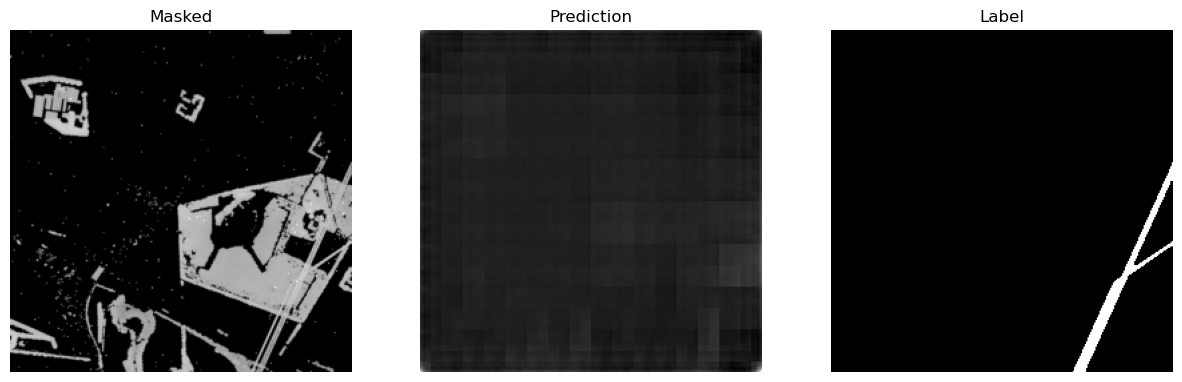

In [14]:
with torch.no_grad():
    for j, data in enumerate(testloader):
        # get the input
        batch_input, batch_labels = data
        for i in range(len(batch_labels)):
            print(i)
            masked, labels = batch_input[i], batch_labels[i]
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))

            ax0.set_title('Masked')
            ax0.imshow(((torch.squeeze(masked.detach())).numpy()),cmap='gray')


            ax1.set_title('Prediction')
            outputs = torch.squeeze(bestModel(masked.cuda())).detach().cpu()
            
            print("Max Outputs: ", torch.max(outputs))
            
            outputs = torch.sigmoid(outputs)
            #outputs = (outputs > 0.3 ).float()
            #print(torch.max(outputs))
            #print(outputs)

            ax1.imshow(((torch.squeeze(outputs.detach())).numpy()),cmap='gray')

            ax2.set_title("Label")
            ax2.imshow(((torch.squeeze(labels.detach())).numpy()),cmap='gray')

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')


0
tensor(-0.1604)
tensor([[-0.2144, -0.3957, -0.5711,  ..., -0.3047, -0.3486, -0.1891],
        [-0.3741, -0.8537, -0.8722,  ..., -0.6509, -0.5599, -0.4249],
        [-0.4046, -0.8539, -0.8712,  ..., -0.6726, -0.5723, -0.4614],
        ...,
        [-0.3080, -0.6957, -0.6960,  ..., -0.5729, -0.4722, -0.3587],
        [-0.2507, -0.5728, -0.5745,  ..., -0.4804, -0.3829, -0.3358],
        [-0.1604, -0.4156, -0.4004,  ..., -0.3261, -0.2767, -0.2155]])
tensor(1.)
1
tensor(-0.1604)
tensor([[-0.2147, -0.3961, -0.5717,  ..., -0.3076, -0.3528, -0.1914],
        [-0.3745, -0.8545, -0.8731,  ..., -0.6572, -0.5645, -0.4290],
        [-0.4049, -0.8546, -0.8720,  ..., -0.6793, -0.5769, -0.4656],
        ...,
        [-0.3081, -0.6958, -0.6962,  ..., -0.5729, -0.4722, -0.3587],
        [-0.2508, -0.5730, -0.5746,  ..., -0.4804, -0.3829, -0.3358],
        [-0.1604, -0.4158, -0.4005,  ..., -0.3261, -0.2767, -0.2155]])
tensor(1.)
2
tensor(-0.1604)
tensor([[-0.2147, -0.3961, -0.5717,  ..., -0.3076, -0.35

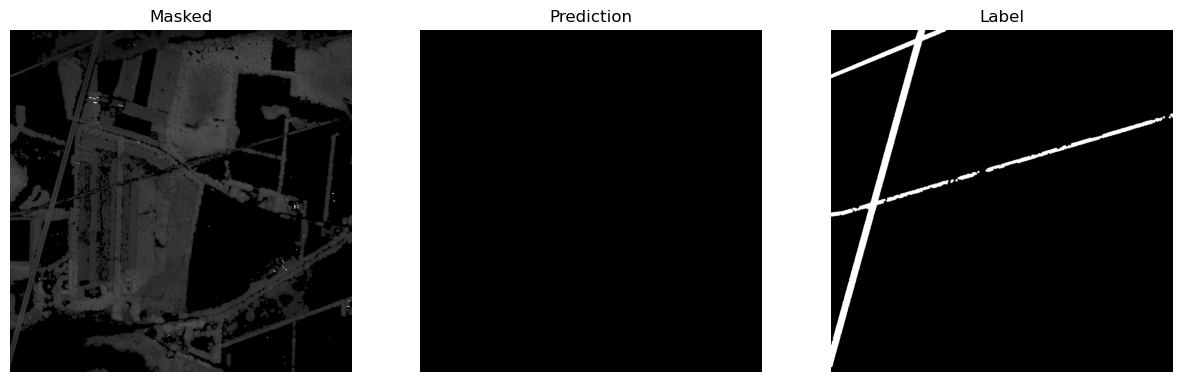

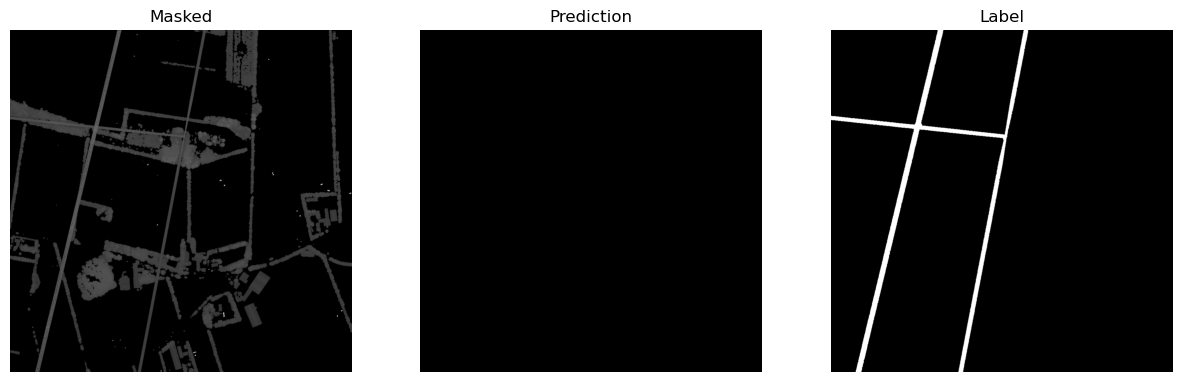

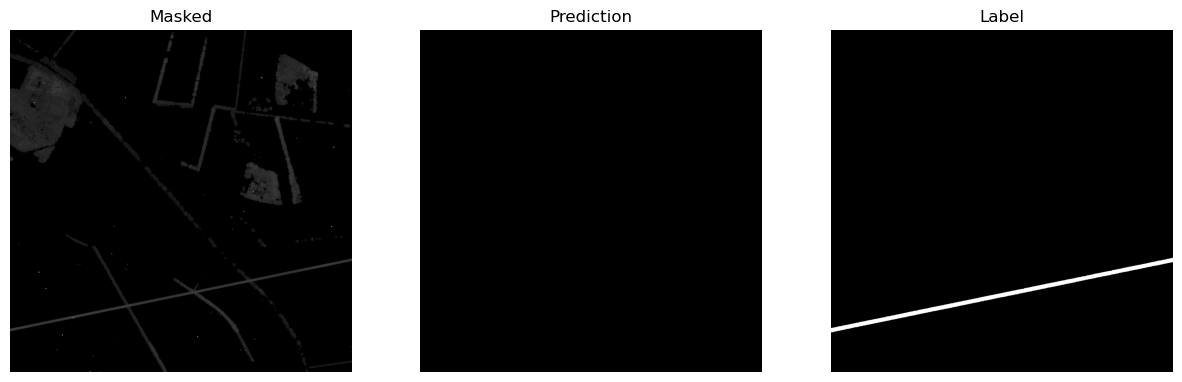

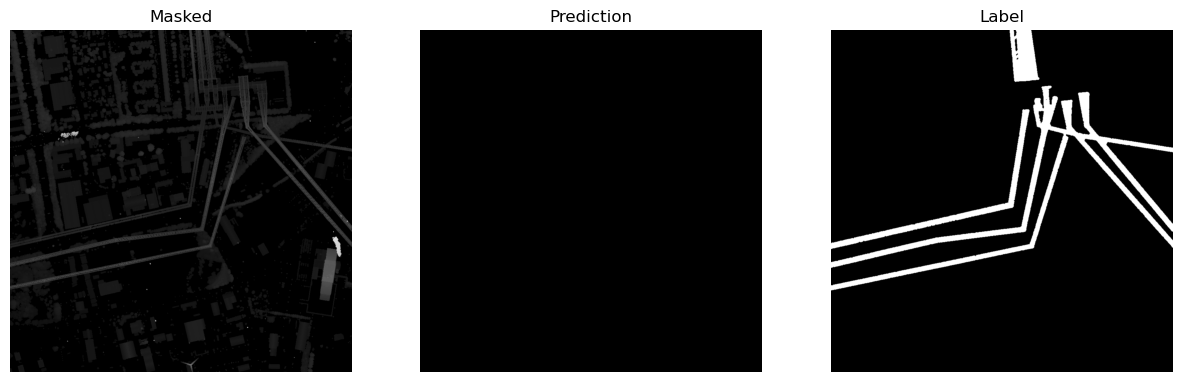

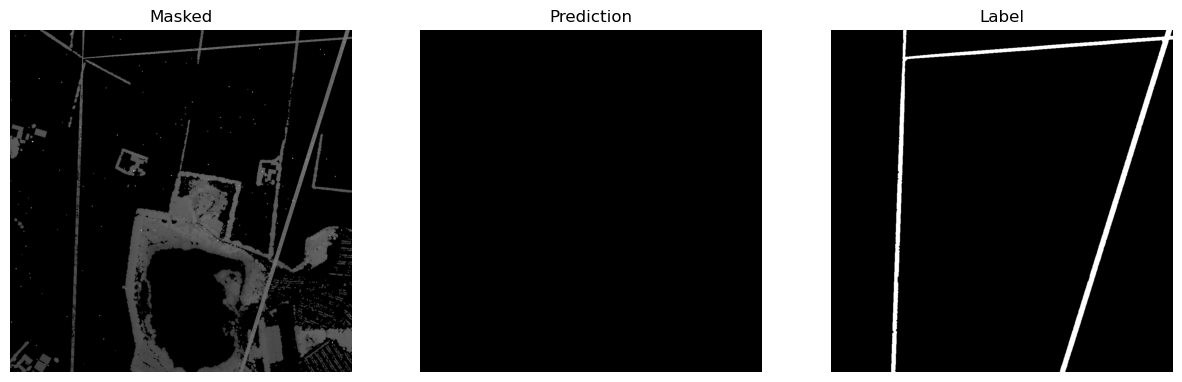

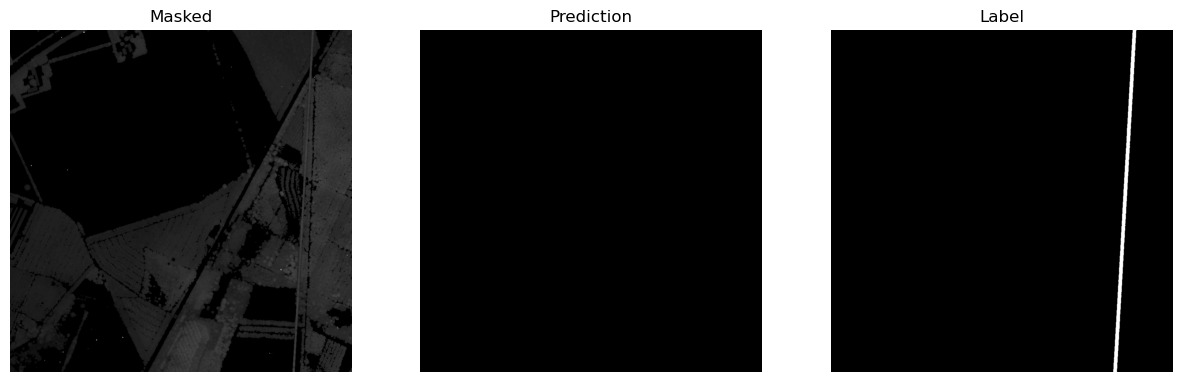

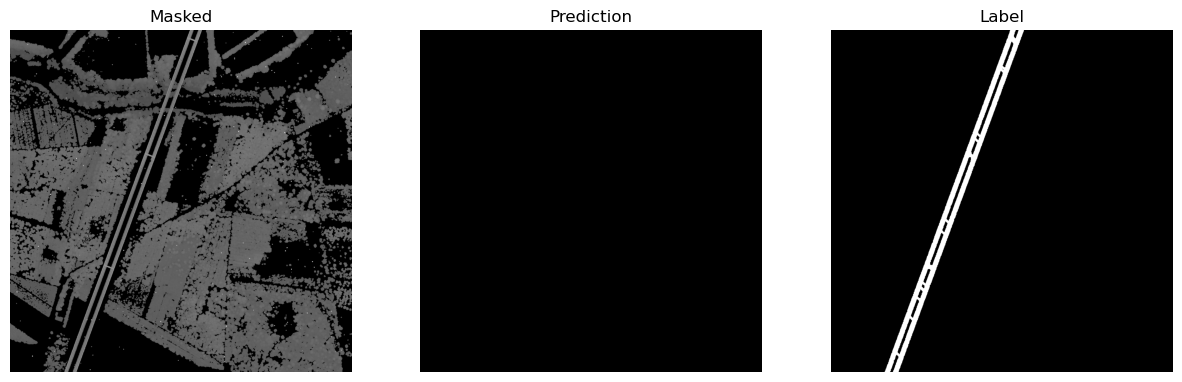

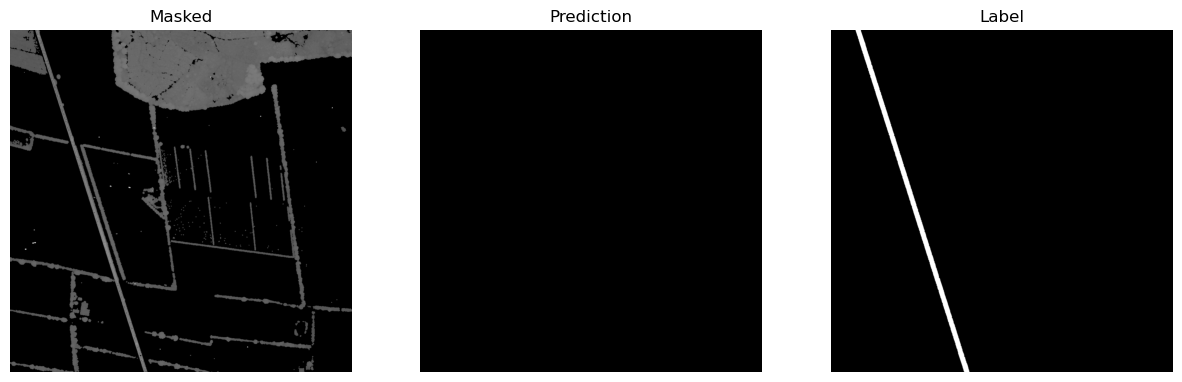

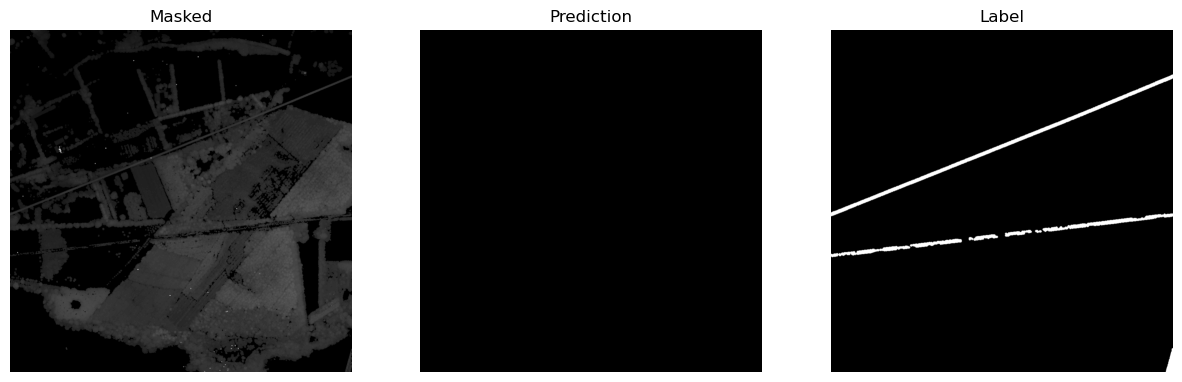

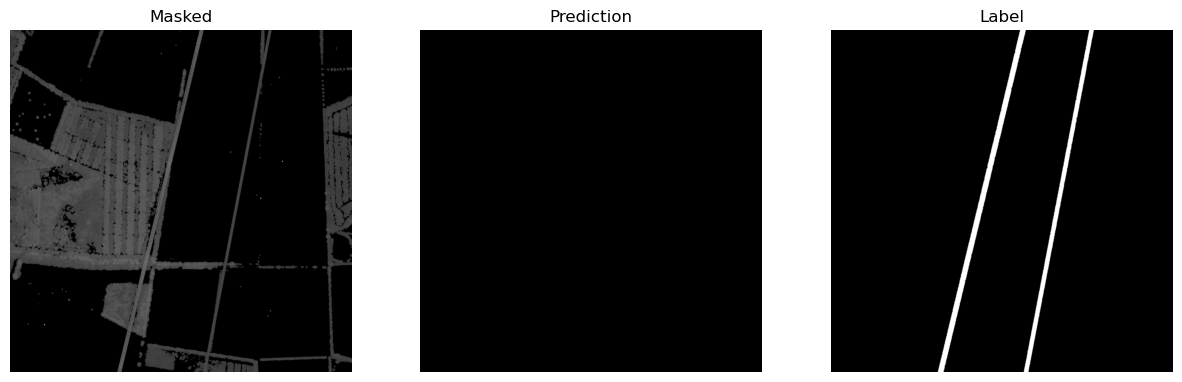

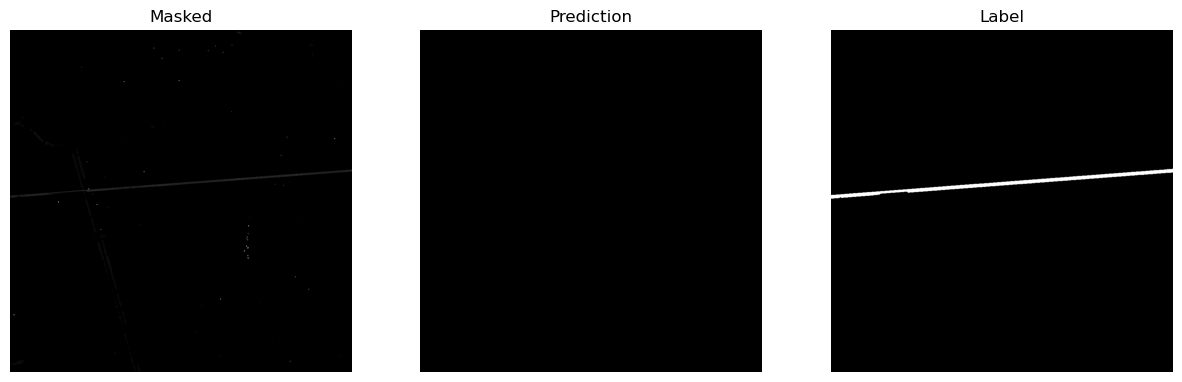

In [23]:
with torch.no_grad():
    for j, data in enumerate(trainloader):
        # get the input
        batch_input, batch_labels = data
        for i in range(len(batch_labels)):
            print(i)
            masked, labels = batch_input[i], batch_labels[i]
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))

            ax0.set_title('Masked')
            ax0.imshow(((torch.squeeze(masked.detach())).numpy()),cmap='gray')


            ax1.set_title('Prediction')
            outputs = torch.squeeze(bestModel(masked.cuda())).detach().cpu()
            cprint(torch.max(outputs))
            print(outputs)
            # outputs = (outputs > 0.01 ).float()
            
            outputs = torch.sigmoid(outputs)
            print(torch.max(outputs))
            # print(outputs)

            ax1.imshow(((torch.squeeze(outputs.detach())).numpy()),cmap='gray')

            ax2.set_title("Label")
            ax2.imshow(((torch.squeeze(labels.detach())).numpy()),cmap='gray')

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')
